# Marigold: Repurposing Diffusion-Based Image Generators for Monocular Depth Estimation

This repository represents the official implementation of the paper titled "Repurposing Diffusion-Based Image Generators for Monocular Depth Estimation".

[![Website](https://img.shields.io/badge/Project-Website-1081c2)](https://arxiv.org/abs/2312.02145)
[![GitHub](https://img.shields.io/github/stars/prs-eth/Marigold?style=default&label=GitHub%20★&logo=github)](https://github.com/prs-eth/Marigold)
[![Paper](https://img.shields.io/badge/arXiv-PDF-b31b1b)](https://arxiv.org/abs/2312.02145)
[![Hugging Face Space](https://img.shields.io/badge/🤗%20Hugging%20Face-Space-yellow)](https://huggingface.co/spaces/toshas/marigold)
[![Hugging Face Model](https://img.shields.io/badge/🤗%20Hugging%20Face-Model-green)](https://huggingface.co/Bingxin/Marigold)
[![License](https://img.shields.io/badge/License-CC_BY--NC--SA_4.0-929292)](LICENSE)

![Teaser](https://share.phys.ethz.ch/~pf/bingkedata/marigold/static/teaser_collage_transparant.png)



All the code necessary to run [Marigold](https://marigoldmonodepth.github.io) is present in this notebook, using google's hardware. To execute a cell, click the *play* button in front.

---

# 🛠️ 1 Setup

In [ ]:
# @title 💻 1.1 Check CUDA and Python Version (tested with CUDA 12.0 + Python 3.10.12)

# This notebook is supposed to be connected to NVIDIA drivers with CUDA.
# If this doesn't load check that GPU is selected as hardware accelerator under Edit -> Notebook settings.
!nvidia-smi
!python -V

Sat Dec 16 17:18:52 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0              30W /  70W |   5777MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# @title 📦 1.2 Clone repository

%%shell
if [ -d "Marigold" ]; then
    cd Marigold
    git pull
else
    git clone https://github.com/prs-eth/Marigold.git
    cd Marigold
fi


In [ ]:
# @title 🔨 1.3 Install dependencies (might take minutes) { vertical-output: true }
%%shell
cd /content/Marigold

pip install -r requirements.txt --upgrade  --quiet

# for progress bar
pip install ipywidgets==7.7.1 --quiet

In [ ]:
# @title 🔧 1.4 Import and initialize

# change model cache directory
!export HF_HOME=$(pwd)/checkpoint


import argparse
import os
from glob import glob
import logging
import shutil


import numpy as np
import torch
from PIL import Image
from tqdm.auto import tqdm


from glob import glob
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import files

from IPython.display import display
import ipywidgets as widgets


# Pre-defined function
def display_images(image_paths, n_images_per_row = 4):
    n_rows = math.ceil(len(image_paths) / n_images_per_row)

    plt.figure(figsize=(10, 2 * n_rows))  # Adjust the size as needed
    for i, img_path in enumerate(image_paths):
        img = mpimg.imread(img_path)
        plt.subplot(n_rows, n_images_per_row, i + 1)  # Number of rows, number of images per row, current index
        plt.imshow(img)
        plt.axis('off')  # To not display axis

    plt.tight_layout()
    plt.show()


# Directories
repo_dir = "/content/Marigold"
input_dir = os.path.join(repo_dir, "input")
output_dir = os.path.join(repo_dir, "output")
output_dir_color = os.path.join(output_dir, "depth_colored")
output_dir_tif = os.path.join(output_dir, "depth_bw")
output_dir_npy = os.path.join(output_dir, "depth_npy")

os.chdir(repo_dir)



---

# 🚀 2 Inference

In [ ]:
# @title 🏇 2.1 Initialize pipeline
from marigold import MarigoldPipeline

pipe = MarigoldPipeline.from_pretrained("Bingxin/Marigold")

pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
# @title 🖼️ 2.2 Prepare input data: Upload input images to "input/" or use our sample images (run cell to generate buttons)

button_download = widgets.Button(description="Use sample images")
button_upload = widgets.Button(description="⬆ Upload images")
button_clear_in = widgets.Button(description="♻ Clear input folder")
button_clear_out = widgets.Button(description="♻ Clear output folder")
out_box = widgets.Output()


def on_button_download_clicked(b):
    out_box.clear_output()
    tmp_dir = "/content/temp"
    os.chdir(repo_dir)
    if os.path.exists(input_dir):
        shutil.rmtree(input_dir)
    with out_box:
        print("downloading sample images")
        !bash script/download_sample_data.sh
    shutil.move(os.path.join(repo_dir, "input", "in-the-wild_example"), tmp_dir)
    shutil.rmtree(input_dir)
    shutil.move(tmp_dir, input_dir)
    with out_box:
        out_box.clear_output()
        print("sample images are downloaded")


def on_button_upload_clicked(b):
    out_box.clear_output()
    os.makedirs(input_dir, exist_ok=True)
    os.chdir(input_dir)
    with out_box:
        uploaded = files.upload()
    os.chdir(repo_dir)

def on_button_clear_in_clicked(b):
    out_box.clear_output()
    shutil.rmtree(input_dir)
    os.makedirs(input_dir)
    with out_box:
        print("Input images are cleared")

def on_button_clear_out_clicked(b):
    out_box.clear_output()
    shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    with out_box:
        print("Output folder is cleared")

button_download.on_click(on_button_download_clicked)
button_upload.on_click(on_button_upload_clicked)
button_clear_in.on_click(on_button_clear_in_clicked)
button_clear_out.on_click(on_button_clear_out_clicked)

widgets.VBox([widgets.HBox([button_upload, button_download]),
              widgets.HBox([button_clear_in, button_clear_out]),
              out_box])


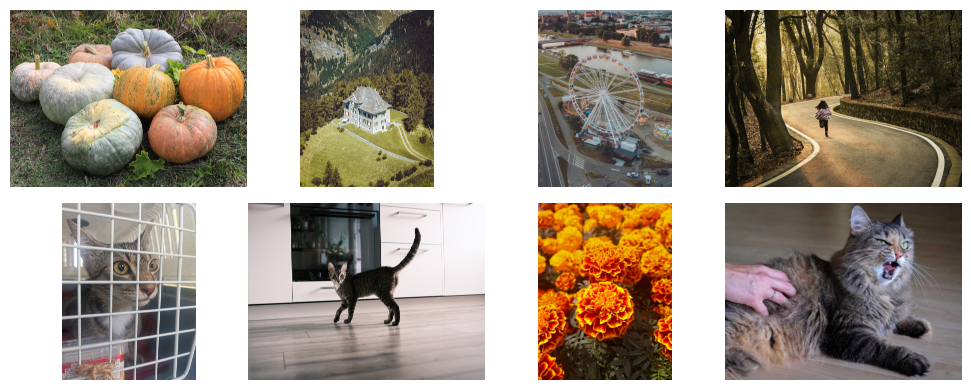

In [ ]:
%matplotlib inline

# @title (optional) 2.3 Display input images

image_paths = glob(os.path.join(input_dir, "*"))

display_images(image_paths)

In [ ]:
# @title ▶️ 2.4 Run inference

EXTENSION_LIST = [".jpg", ".jpeg", ".png"]

# Image list
rgb_filename_list = glob(os.path.join(input_dir, "*"))
rgb_filename_list = [
    f for f in rgb_filename_list if os.path.splitext(f)[1].lower() in EXTENSION_LIST
]
rgb_filename_list = sorted(rgb_filename_list)

# Create output folders
os.makedirs(output_dir, exist_ok=True)
os.makedirs(output_dir_color, exist_ok=True)
os.makedirs(output_dir_tif, exist_ok=True)
os.makedirs(output_dir_npy, exist_ok=True)

# Run Inference
with torch.no_grad():
    os.makedirs(output_dir, exist_ok=True)

    for rgb_path in tqdm(rgb_filename_list, desc=f"Estimating depth", leave=True):
        # Read input image
        input_image = Image.open(rgb_path)

        # Predict depth
        pipeline_output = pipe(
            input_image,
            denoising_steps=10,     # optional
            ensemble_size=10,       # optional
            processing_res=768,     # optional
            match_input_res=True,   # optional
            batch_size=0,           # optional
            color_map="Spectral",   # optional
            show_progress_bar=True, # optional
        )

        depth_pred: np.ndarray = pipeline_output.depth_np
        depth_colored: Image.Image = pipeline_output.depth_colored

        # Save as npy
        rgb_name_base = os.path.splitext(os.path.basename(rgb_path))[0]
        pred_name_base = rgb_name_base + "_pred"
        npy_save_path = os.path.join(output_dir_npy, f"{pred_name_base}.npy")
        if os.path.exists(npy_save_path):
            logging.warning(f"Existing file: '{npy_save_path}' will be overwritten")
        np.save(npy_save_path, depth_pred)

        # Save as 16-bit uint png
        depth_to_save = (depth_pred * 65535.0).astype(np.uint16)
        png_save_path = os.path.join(output_dir_tif, f"{pred_name_base}.png")
        if os.path.exists(png_save_path):
            logging.warning(f"Existing file: '{png_save_path}' will be overwritten")
        Image.fromarray(depth_to_save).save(png_save_path, mode="I;16")

        # Colorize
        colored_save_path = os.path.join(
            output_dir_color, f"{pred_name_base}_colored.png"
        )
        if os.path.exists(colored_save_path):
            logging.warning(f"Existing file: '{colored_save_path}' will be overwritten")
        depth_colored.save(colored_save_path)

Estimating depth:   0%|          | 0/8 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

  Inference batches:   0%|          | 0/5 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

    Diffusion denoising:   0%|          | 0/10 [00:00<?, ?it/s]

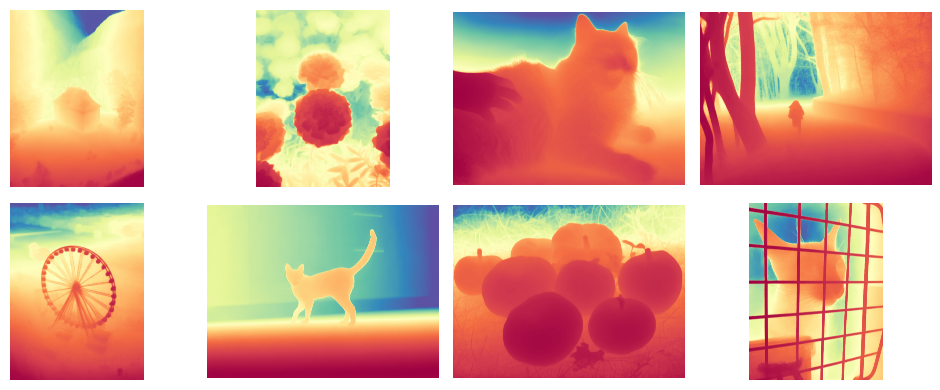

In [ ]:
%matplotlib inline

# @title (optional) 2.5 Display predictions

output_images_colored  = glob(os.path.join(output_dir_color, "*"))
display_images(output_images_colored)
